# Devoir Python

Vous devez rendre votre devoir sur GitHub.
Vous avez le droit a tout vos documents et a internet

1. votre depot doit etre privé
2. vous devez inviter comme colaborateur votre chargé de TD/TP
3. Seul le dernier commit avant la fin de la séance sera corrigé.


Ex 1: Integrale de Romberg

Ecrire une fonction integ_romberg(f, a, b, epsilon=1e-6) permettant de calculer l’intégrale numérique de la fonction f entre les bornes a et b avec une précision epsilon selon la méthode de Romberg (https://fr.wikipedia.org/wiki/M%C3%A9thode_de_Romberg).

Il s’agit d’une méthode qui permet d’améliorer les méthodes usuelles de calcul numérique des intégrales, comme la méthode des Trapèzes.
On montre qu’en combinant judicieusement les valeurs obtenues par la méthode des Trapèzes pour différentes subdivisons de l’intervalle d’intégration, on augmente l’ordre de convergence (sa vitesse de convergence). 


In [28]:
#on s'aide du wiki pour trouver un algorithme
import numpy as numpy

class Romberg:
    #on initialise les differentes variables qui vont nous servir par la suite
    def __init__(self,f,a,b): 
        self.f = f
        self.a = a
        self.b = b
        self.p = 0#puissance de N
        self.N = 1 #Nombre d'intrvalle entre [a;b], c'est une puissance de 2
        self.S = 0.5*(f(a)+f(b)) #Somme
        self.h = (b-a) #distance entre le point a et b
        self.I = self.S*self.h
        self.I_last = self.I #dernie rI
        self.n_eval = 0
        
    def iteration(self):
        self.n_eval += self.N
        x = self.a+self.h*0.5
        somme = self.f(x)
        for k in range(self.N-1):
            x += self.h
            somme += f(x)
        self.N *= 2
        self.p += 1
        self.S += somme
        self.h *= 0.5
        self.I_last = self.I
        self.I = self.h*self.S
        
    def iterations(self,P):
        I = [self.I]
        h = [self.h]
        while self.p<P:
            self.iteration()
            I.append(self.I)
            h.append(self.h)
        return (numpy.array(h),numpy.array(I)) 
    
    def trapezes(self,epsilon):
        I = [self.I]
        h = [self.h]
        self.iteration()
        while abs(self.I-self.I_last)>epsilon:
            self.iteration()
            I.append(self.I)
            h.append(self.h)
        return (numpy.array(h),numpy.array(I))
    
    def romberg(self,epsilon):
        jmax = 20
        A=numpy.zeros((jmax+1,jmax+1))
        A[0][0] = self.I
        self.iteration()
        A[1][0] = self.I
        correction = (A[1][0]-A[0][0])/3
        A[1][1] = A[1][0] + correction
        j = 2
        while abs(correction) > epsilon:
            self.iteration()
            A[j][0] = self.I
            for i in range(1,j+1):
                correction = (A[j][i-1]-A[j-1][i-1])/(4**i-1)
                A[j][i] = A[j][i-1] + correction
            j += 1
        return (A[0:j-1,0:j-1],A[j-1][j-1])

In [31]:
def f(x):
    return x**2
romberg = Romberg(f,0,1)
(h,I) = romberg.trapezes(1e-6)

In [32]:
print(I[-1]-1.0/6)

0.16666682561238608


In [93]:
"""ne marche pas
import numpy as numpy


def fonction(x): 
    return x

def integ_romberg(a, b, epsilon=1e-6) :
    Somme=0
    N=(b-a)/epsilon
    N=int(N)
    print(N)
    for i in range(0,N):
        if i == 0:
            Somme=Somme+0.5*fonction(i)
        if i == N:
            Somme=Somme+0.5*fonction(i)
        else :
            Somme=Somme+fonction(i)
    h=(b-a)/N
    print(h)
    print(Somme)
    return h*Somme
""" 

In [94]:
#integ_romberg(1,2,1e-6)

1000000
1e-06
499999500000.0


499999.5

Ex 2: Équation d’état de l’eau à partir de la dynamique moléculaire

Afin de modéliser les planètes de type Jupiter, Saturne, ou même des exo-planètes très massives (dites « super-Jupiters »), la connaissance de l’équation d’état des composants est nécessaire. Ces équations d’état doivent être valables jusqu’à plusieurs centaines de méga-bar ; autrement dit, celles-ci ne sont en aucun cas accessibles expérimentalement. On peut cependant obtenir une équation d’état numériquement à partir d’une dynamique moléculaire.

Le principe est le suivant : on place dans une boite un certain nombre de particules régies par les équations microscopiques (Newton par exemple, ou même par des équations prenant en considération la mécanique quantique) puis on laisse celles-ci évoluer dans la boite ; on calcule à chaque pas de temps l’énergie interne à partir des intéractions électrostatiques et la pression à partir du tenseur des contraintes. On obtient en sortie l’évolution du système pour une densité fixée (par le choix de taille de la boite) et une température fixée (par un algorithme de thermostat que nous ne détaillerons pas ici).

On se propose d’analyser quelques fichiers de sortie de tels calculs pour l’équation d’état de l’eau à très haute pression. Les fichiers de sortie sont disponibles ici; leur nom indique les conditions thermodynamiques correspondant au fichier, p.ex. 6000K_30gcc.out pour T=6000
K et ρ=30 gcc. Le but est, pour chaque condition température-densité, d’extraire l’évolution de l’énergie et de la pression au cours du temps, puis d’en extraire la valeur moyenne ainsi que les fluctuations. Il arrive souvent que l’état initial choisi pour le système ne corresponde pas à son état d’équilibre, et qu’il faille donc « jeter » les quelques pas de temps en début de simulation qui correspondent à cette relaxation du système. Pour savoir combien de temps prend cette relaxation, il sera utile de tracer l’évolution au cours du temps de la pression et l’énergie pour quelques simulations. Une fois l’équation d’état P(ρ,T) et E(ρ,T) extraite, on pourra tracer le réseau d’isothermes.

In [104]:

import numpy as N
import matplotlib.pyplot as P

import pytest                    # pytest importe pour les tests unitaires

"""
Construction d'un système d'extraction et d'analyse de fichiers de sortie de
dynamique moléculaire afin d'extraire les grandeurs thermodynamiques.
On affichera les ensuite isothermes.
"""

tolerance = 1e-8  # Un seuil de tolérance pour les égalités sur réels


class Simulation:
    """
    La classe Simulation représente une simulation de dynamique
    moléculaire, donc un point de l'équation d'état. Son constructeur
    doit impérativement être appelé avec le chemin du fichier output
    correspondant. Elle possède des méthodes pour extraire les grandeurs
    thermodynamiques et afficher la run, en pouvant enlever certains pas
    de temps en début de simulation.
    """

    def __init__(self, temp, dens, path):
        """
        Le constructeur doit impérativement être appelé avec le chemin du
        fichier décrivant la simulation, ainsi que ses conditions
        thermodynamiques.

        Args :
                temp,dens(float): La température et la densité de la simulation
                path(string): Le chemin vers le fichier décrivant la simulation

        Raises :
                TypeError si temp ou dens ne sont pas des réels
                IOError si le fichier n'existe pas
        """
        self.temp = float(temp)
        self.dens = float(dens)
        tmp = N.loadtxt(path, skiprows=1).T
        self.pot = tmp[0]
        self.kin = tmp[1]
        self.tot = self.pot + self.kin
        self.press = tmp[2]


    def thermo(self, skipSteps=0):
        """
        Calcule l'énergie et la pression moyenne au cours de la simulation.
        Renvoie un dictionnaire.

        Args:
                skipSteps(int): Nb de pas à enlever en début de simulation.

        Returns:
                {'T':temperature, 'rho':density,
                 'E':energy, 'P':pressure,
                 'dE':dEnergy, 'dP':dPressure}
        """
        return {'T': self.temp,
                'rho': self.dens,
                'E': self.tot[skipSteps:].mean(),
                'P': self.press[skipSteps:].mean(),
                'dE': self.tot[skipSteps:].std(),
                'dP': self.press[skipSteps:].std()}

    def plot(self, skipSteps=0):
        """
        Affiche l'évolution de la Pression et l'énergie interne au cours de
        la simulation.

        Args:
                skipSteps(int): Pas de temps à enelevr en début de simulation.

        Raises:
                TypeError si skipSteps n'est pas un entier.
        """
        fig, (axen, axpress) = P.subplots(2, sharex=True)
        axen.plot(list(range(skipSteps, len(self.tot))), self.tot[skipSteps:],
                  'rd--')
        axen.set_title("Internal energy (Ha)")
        axpress.plot(list(range(skipSteps, len(self.press))), self.press[skipSteps:],
                     'rd--')
        axpress.set_title("Pressure (GPa)")
        axpress.set_xlabel("Timesteps")

        P.show()

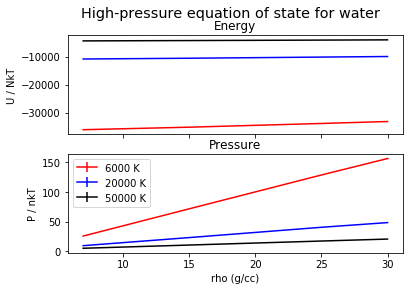

In [106]:

if __name__ == '__main__':
    """
    On définit un certain nombre de pas de temps à sauter, puis on
    charge chaque simulation et extrait les informaions thermodynamiques
    associées. On affiche enfin les isothermes normalisées (E/NkT et P/nkT).
    """

    ### Definitions ###
    a0 = 0.52918      # Bohr radius in angstrom
    amu = 1.6605      # atomic mass unit in e-24 g
    k_B = 3.16681e-6  # Boltzmann's constant in Ha/K
    # normalization factor for P/nkT
    nk_GPa = a0 ** 3 * k_B * 2.942e4 / 6 / amu
    nsteps = 200  # define skipped timesteps (should be done for
    # each simulation...)
    temps = [6000, 20000, 50000]    # define temperatures
    colors = {6000: 'r', 20000: 'b', 50000: 'k'}
    denss = [7, 15, 25, 30]  # define densities
    keys = ['T', 'rho', 'E', 'dE', 'P', 'dP']
    eos = dict.fromkeys(keys, N.zeros(0))   # {key:[]}

    ### on extrait les fichier .out fournis ###
    for t, rho in [(t, rho) for t in temps for rho in denss]:
        filenm = "outputs(1)/outputs/{}K_{:0>2d}gcc.out".format(t, rho) #on modifie le chemin pour acceder aux fichiers
        s = Simulation(t, rho, filenm) #on fait la simulation
        for key in keys:
            eos[key] = N.append(eos[key], s.thermo(nsteps)[key])

    ### on affiche les courbes de l'énerge en fonction de la pression ###
    fig, (axen, axpress) = P.subplots(2, sharex=True)
    #On définit les titres des courbes :
    fig.suptitle("High-pressure equation of state for water", size='x-large')
    axen.set_title("Energy")
    axen.set_ylabel("U / NkT")
    axpress.set_title("Pressure")
    axpress.set_ylabel("P / nkT")
    axpress.set_xlabel("rho (g/cc)")
    for t in temps:
        sel = eos['T'] == t
        axen.errorbar(x=eos['rho'][sel], y=eos['E'][sel] / k_B / t,
                      yerr=eos['dE'][sel] / k_B / t, fmt=colors[t] + '-')
        axpress.errorbar(x=eos['rho'][sel],
                         y=eos['P'][sel] / eos['rho'][sel] / nk_GPa / t,
                         yerr=eos['dP'][sel] / eos['rho'][sel] / nk_GPa / t,
                         fmt=colors[t] + '-',
                         label="{} K".format(t))
    axpress.legend(loc='best')
    P.show()

Ex 3: Le problème du voyageur de commerce

Le problème du voyageur de commerce est un problème d’optimisation consistant à déterminer le plus court chemin reliant un ensemble de destinations. Il n’existe pas d’algorithme donnant la solution optimale en un temps raisonnable (problème NP-complet), mais l’on peut chercher à déterminer des solutions approchées. On va se placer ici dans le cas d’un livreur devant desservir une seule fois chacune desndestinations d’une ville américaine où les rues sont agencées en réseau carré. 

On utilise la « distance deManhattan »  entre deux points 𝐴(𝑥𝐴,𝑦𝐴) et 𝐵(𝑥𝐵,𝑦𝐵) : 𝑑(𝐴,𝐵) =|𝑥𝐵−𝑥𝐴|+|𝑦𝐵−𝑦𝐴|.

En outre, on se place dans le cas où les coordonnées des destinations sont entières, comprises entre 0 (inclus) et TAILLE = 50 (exclus). Deux destinations peuvent éventuellement avoir les mêmes coordonnées. Les instructions suivantes doivent permettre de définir les classes nécessaires (Ville et Trajet) et de développer un algorithme approché (heuristiques) : l’algorithme du plus proche voisin. 

Seules la librairie standard et la librairie numpy sont utilisables si nécessaire. Implementer les classes et methodes suivante:


Classe Ville:
* __init__(): initialisation d’une ville sans destination.
* aleatoire(n): création de n destinations aléatoires.
* nb_trajet(): retourne le nombre total (entier) de trajets :(𝑛−1)!/2(utilisermath.factorial()).
* distance(i, j): retourne la distance (Manhattan) entre les deux destinations de numéro i et j


Classe Trajet:
* __init__(ville, etapes=None): initialisation sur une ville. Si la liste etapes n’est pas spécifiée, le trajet par défaut est celui suivant les destinations de ville.
* longueur(): retourne la longueur totale du trajetbouclé(i.e. revenant à son point de départ).


Plus proche voisin:
* Ville.plus_proche(i, exclus=[]): retourne la destination la plus proche de la destinationi(au sens de Ville.distance()), hors les destinations de la liste exclus
* Ville.trajet_voisins(depart=0): retourne un Trajet déterminé selon l’heuristique des plus proches voisins (i.e. l’étape suivante est la destination la plus proche hors les destinations déjà visitées) en partant de l’étape initiale depart

Optimisation:
* Proposer un algorithme qui propose une meilleur alternative au "plus proche voisin".

Interface:
* Ville.figure(trajet=None): Afficher le plande la ville et le trajet obtenue (utiliser matplotlib.step()pour des trajets de type « Manhattan »)

In [111]:
import math
import numpy as N

N.random.seed(123) #pour definir des valeurs aleatoires
TAILLE = 20 #nombre de destination aleatoires

class Ville(object):

    """
    Ville, contient une liste (non-ordonnée) de destinations.
    """

    def __init__(self):
        """Initialisation d'une ville sans destination."""

        self.destinations = N.array([]).reshape(-1, 2)

    def aleatoire(self, n=20):
        """Création de *n* destinations aléatoires."""

        self.destinations = N.random.randint(TAILLE, size=(n, 2))

    def nb_trajets(self):
        """retourne le nombre total (entier) de trajets :
        (𝑛−1)!/2(utilisermath.factorial())."""

        dest = len(self.destinations)#nombre de destinations
        if dest > 2:
            return int(math.factorial(dest - 1) / 2)#on fait la facorielle
        elif dest > 0:
            return 1
        else:
            return 0

    def distance(self, i, j):
        """
        Retourne la distance (Manhattan) entre les deux destinations de numéro i et j, 
        
        """

        return N.abs(self.destinations[i] - self.destinations[j]).sum()#on utilise la valeur absolue pour ne pas avoir de chiffre négatif
    
    def plus_proche(self, i, exclus=[]):
        """
        Retourne la destination la plus proche de la destination *i*, hors les
        destinations de la liste `exclus`.
        """

        voisins = [ j for j in range(len(self.destinations)) #range dans voisin le nombre de l'entiereté des destinations
                    if j != i and j not in exclus ] #sauf ceux que l'on a exclu
        distances = [ self.distance(i, j) for j in voisins ]#calcule les distances de toutes les destinations

        return voisins[N.argmin(distances)] #argmin : renvoie la plus petite valeur
    
    def trajet_voisins(self, depart=0):
        """
        retourne un Trajet déterminé selon l’heuristique des plus proches voisins 
        (i.e. l’étape suivante est la destination la plus proche hors les destinations déjà visitées) 
        en partant de l’étape initiale depart
        """

        dest = len(self.destinations)
        if depart is None:     # Boucle sur tous les départs possibles
            trajets = [ self.trajet_voisins(depart=i) for i in range(dest) ]
            longueurs = [ t.longueur() for t in trajets ]

            return trajets[N.argmin(longueurs)]#retourne la plus petite valeur de longueurs
        else:                  # Départ imposé
            etapes = [depart]
            while len(etapes) < dest:
                i = etapes[-1]
                j = self.plus_proche(i, exclus=etapes[:-1])
                etapes.append(j)

            return Trajet(self, etapes)

class Trajet(object):

    """
    Trajet, contient une liste ordonnée des destinations (étapes) d'une
    Ville.
    """

    def __init__(self, ville, etapes=None):
        """
        initialisation sur une ville. Si la liste etapes n’est pas spécifiée,
        le trajet par défaut est celui suivant les destinations de ville.
        """

        assert isinstance(ville, Ville)
        self.ville = ville #définit la ville
        if etapes is None:                     # Trajet par défaut
            self.etapes = N.arange(len(self.ville.destinations))
        else:
            self.etapes = N.array(etapes) #crée un tableau avec les etapes qu'on lui a passé

    def longueur(self):
        """
        retourne la longueur totale du trajet bouclé(i.e. revenant à son point de départ).
        """

        l = sum( self.ville.distance(self.etapes[i], self.etapes[i+1]) #addition de la distance des villes
                 for i in range(len(self.etapes)-1) )
        l += self.ville.distance(self.etapes[-1], self.etapes[0]) 

        return l #on retourne le longueur du trajet

    
    